Implementation of 2D elasto-plastic problem using FEniCS-X. The code is based on a [legacy solution](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html) for FEniCS 2019.

The program was tested for 0.3.1.0 version of Dolfinx.

In [1]:
import meshio
import numpy as np

import ufl
from dolfinx import fem, io
from mpi4py import MPI
from petsc4py import PETSc
import time

# import basix

import sys
sys.path.append("../..")
import fenicsx_support as fs

In [2]:
if MPI.COMM_WORLD.rank == 0:

    #It works with the msh4 only!!
    msh = meshio.read("thick_cylinder.msh")

    # Create and save one file for the mesh, and one file for the facets 
    triangle_mesh = fs.create_mesh(msh, "triangle", prune_z=True)
    line_mesh = fs.create_mesh(msh, "line", prune_z=True)
    meshio.write("thick_cylinder.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)
    print(msh)
    


<meshio mesh object>
  Number of points: 811
  Number of cells:
    line: 10
    line: 69
    line: 10
    line: 53
    triangle: 1478
  Cell sets: gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical


In [3]:
with io.XDMFFile(MPI.COMM_WORLD, "thick_cylinder.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")

mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)

with io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

In [4]:
# elastic parameters

sig0_dim = 1. #[Pa]
Ri_dim = 1.0 #[m]

E = 70e3 / sig0_dim
nu = 0.3
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = fem.Constant(mesh, PETSc.ScalarType(E/2./(1+nu)))
k = lmbda + 2*mu/3 # Bulk modulus 
alpha = 0.03

sig0 = fem.Constant(mesh, PETSc.ScalarType(250 / sig0_dim))  # yield strength
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus

M = (3*mu + 3*alpha*alpha * (2*mu + 3*k)) / np.sqrt(1 + 2*alpha) + H

Re, Ri = 1.3, 1.   # external/internal radius

In [5]:
deg_u = 2
deg_stress = 2
V = fem.VectorFunctionSpace(mesh, ("CG", deg_u))
We = ufl.VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default')
W0e = ufl.FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
WTe = ufl.TensorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, shape=(4, 4), quad_scheme='default')

W = fem.FunctionSpace(mesh, We)
W0 = fem.FunctionSpace(mesh, W0e)
WT = fem.FunctionSpace(mesh, WTe)

In [6]:
sig = fem.Function(W)
sig_old = fem.Function(W)
n_elas = fem.Function(W)
beta = fem.Function(W0)
p = fem.Function(W0, name="Cumulative_plastic_strain")
dp = fem.Function(W0)
u = fem.Function(V, name="Total_displacement")
du = fem.Function(V, name="Iteration_correction")
Du = fem.Function(V, name="Current_increment")
v = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)

C_tang = fem.Function(WT)

P0 = fem.FunctionSpace(mesh, ("DG", 0))
p_avg = fem.Function(P0, name="Plastic_strain")

In [7]:
left_marker = 3
down_marker = 1
left_facets = ft.indices[ft.values == left_marker]
down_facets = ft.indices[ft.values == down_marker]
left_dofs = fem.locate_dofs_topological(V.sub(0), mesh.topology.dim-1, left_facets)
down_dofs = fem.locate_dofs_topological(V.sub(1), mesh.topology.dim-1, down_facets)

bcs = [fem.dirichletbc(PETSc.ScalarType(0), left_dofs, V.sub(0)), fem.dirichletbc(PETSc.ScalarType(0), down_dofs, V.sub(1))]

In [8]:
n = ufl.FacetNormal(mesh)
q_lim = float(2/np.sqrt(3)*np.log(Re/Ri)*sig0.value)

loading = fem.Constant(mesh, PETSc.ScalarType(0.0 * q_lim))

def F_ext(v):
    return -loading * ufl.inner(n, v)*ds(4)

def eps(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_tensor([[e[0, 0], e[0, 1], 0],
                          [e[0, 1], e[1, 1], 0],
                          [0, 0, 0]])

def sigma(eps_el):
    return lmbda*ufl.tr(eps_el)*ufl.Identity(3) + 2*mu*eps_el

def as_3D_tensor(X):
    return ufl.as_tensor([[X[0], X[3], 0],
                          [X[3], X[1], 0],
                          [0, 0, X[2]]])

ppos = lambda x: (x + ufl.sqrt(x**2))/2.
def proj_sig(deps, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(deps)
    s = ufl.dev(sig_elas)
    sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    tr_sig = ufl.tr(sig_elas)
    f_elas = sig_eq + alpha*tr_sig - sig0 - H*old_p
    dp = ppos(f_elas)/M
    n_elas = s/sig_eq*ppos(f_elas)/f_elas
    beta = 3*mu*dp/sig_eq
    new_sig = sig_elas - (beta*s + dp * alpha*(2*mu + 3*k) * ufl.Identity(3)) / np.sqrt(1 + 2*alpha)
    return ufl.as_vector([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1]]), \
           ufl.as_vector([n_elas[0, 0], n_elas[1, 1], n_elas[2, 2], n_elas[0, 1]]), \
           beta, dp       

def sigma_tang(e):
    N_elas = as_3D_tensor(n_elas)
    # return sigma(e) - 3*mu*(3*mu/(3*mu+H)-beta)*ufl.inner(N_elas, e)*N_elas - 2*mu*beta*ufl.dev(e)  
    
    return sigma(e) - (2*mu + 3*k) / np.sqrt(1 + 2*alpha) * (1.5*(3*mu / M - beta) * ufl.inner(N_elas, e)* N_elas - 4.5*alpha*k/M * ufl.tr(e) * N_elas + 3*mu*alpha/M * ufl.inner(N_elas, e) * ufl.Identity(3) + beta * ufl.dev(e) )

In [9]:
ds = ufl.Measure("ds", domain=mesh, subdomain_data=ft)
dx = ufl.Measure(
    "dx",
    domain=mesh,
    metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"},
)

a_Newton = ufl.inner(eps(v), sigma_tang(eps(u_)))*dx
res = -ufl.inner(eps(u_), as_3D_tensor(sig))*dx + F_ext(u_)

In [10]:
problem = fem.petsc.LinearProblem(
    a_Newton,
    res,
    bcs=bcs,
    petsc_options={
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
)

form_res = fem.form(res)
form_a_Newton = fem.form(a_Newton)

b = fem.petsc.create_vector(form_res)
A = fem.petsc.create_matrix(form_a_Newton)

with b.localForm() as b_local:
    b_local.set(0.0)
fem.petsc.assemble_vector(b, form_res)
b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
fem.set_bc(b, bcs)

A.zeroEntries()
fem.petsc.assemble_matrix(A, form_a_Newton, bcs=bcs)
A.assemble()

solver = PETSc.KSP().create(mesh.comm)
solver.setType("preonly")
solver.getPC().setType("lu")
solver.setOperators(A)

In [11]:
# Defining a cell containing (Ri, 0) point, where we calculate a value of u
x_point = np.array([[Ri, 0, 0]])
cells, points_on_proc = fs.find_cell_by_point(mesh, x_point)

In [12]:
Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))
load_steps = load_steps
# xdmf = io.XDMFFile(MPI.COMM_WORLD, "plasticity.xdmf", "w", encoding=io.XDMFFile.Encoding.HDF5)
# xdmf.write_mesh(mesh)

sig.vector.set(0.0)
sig_old.vector.set(0.0)
p.vector.set(0.0)
u.vector.set(0.0)
n_elas.vector.set(0.0)
beta.vector.set(0.0)

return_mapping_times = np.zeros((len(load_steps)))

start = time.time()

for (i, t) in enumerate(load_steps):
    return_mapping_times_tmp = []
    loading.value = t * q_lim

    with b.localForm() as b_local:
        b_local.set(0.0)
    b = fem.petsc.assemble_vector(form_res)
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.set_bc(b, bcs)

    nRes0 = b.norm() # Which one? - ufl.sqrt(Res.dot(Res))
    nRes = nRes0
    Du.x.array[:] = 0

    if MPI.COMM_WORLD.rank == 0:
        print(f"\nnRes0 , {nRes0} \n Increment: {str(i+1)}, load = {t * q_lim}")
    niter = 0


    while nRes/nRes0 > tol and niter < Nitermax:
        solver.solve(b, du.vector)
        # print('du', np.max(du.x.array), np.min(du.x.array), du.vector.norm())

        Du.vector.axpy(1, du.vector) # Du = Du + 1*du
        Du.x.scatter_forward() 

        start_interpolate = time.time()

        deps = eps(Du)
        sig_, n_elas_, beta_, dp_ = proj_sig(deps, sig_old, p)

        fs.interpolate_quadrature(sig_, sig)
        fs.interpolate_quadrature(n_elas_, n_elas)
        fs.interpolate_quadrature(beta_, beta)
        fs.interpolate_quadrature(dp_, dp)
        print('n_elas', np.max(n_elas.x.array), np.min(n_elas.x.array), n_elas.vector.norm())
        print('sig', np.max(sig.x.array), np.min(sig.x.array), sig.vector.norm())
        print('beta', np.max(beta.x.array), np.min(beta.x.array), beta.vector.norm())
        # print('d', np.max(d.x.array), np.min(d.x.array), d.vector.norm())

        return_mapping_times_tmp.append(time.time() - start_interpolate)

        A.zeroEntries()
        fem.petsc.assemble_matrix(A, form_a_Newton, bcs=bcs)
        A.assemble()
        with b.localForm() as b_local:
            b_local.set(0.0)
        fem.petsc.assemble_vector(b, form_res)

        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        fem.set_bc(b, bcs)

        nRes = b.norm() 
        if MPI.COMM_WORLD.rank == 0:
            print(f"    Residual: {nRes}")
        niter += 1
    u.vector.axpy(1, Du.vector) # u = u + 1*Du
    u.x.scatter_forward()

    fs.interpolate_quadrature(dp_, dp)
    p.vector.axpy(1, dp.vector)
    p.x.scatter_forward()
    print('p after copy', np.max(p.x.array), np.min(p.x.array), p.vector.norm())
    
    sig_old.x.array[:] = sig.x.array[:]

    # fs.project(p, p_avg)
    
    # xdmf.write_function(u, t)
    # xdmf.write_function(p_avg, t)

    return_mapping_times[i] = np.mean(return_mapping_times_tmp)
    print(f'rank#{MPI.COMM_WORLD.rank}: Time (mean return mapping) = {return_mapping_times[i]:.3f} (s)')

    if len(points_on_proc) > 0:
        results[i+1, :] = (u.eval(points_on_proc, cells)[0], t)

# xdmf.close()
# end = time.time()
print(f'\n rank#{MPI.COMM_WORLD.rank}: Time (return mapping) = {np.mean(return_mapping_times):.3f} (s)')
print(f'rank#{MPI.COMM_WORLD.rank}: Time = {time.time() - start:.3f} (s)')


nRes0 , 2.853682384400221 
 Increment: 1, load = 17.7621446711497
n_elas 0.0 0.0 0.0
sig 68.92404472200207 -43.19559283092393 0.0
beta 0.0 0.0 0.0
    Residual: 4.761179418810954e-12
p after copy 0.0 0.0 0.0
rank#0: Time (mean return mapping) = 0.079 (s)

nRes0 , 1.182033946323497 
 Increment: 2, load = 25.119465890772904
n_elas 0.0 0.0 0.0
sig 97.47331881938068 -61.087793216231546 0.0
beta 0.0 0.0 0.0
    Residual: 1.9428834879936643e-12
p after copy 0.0 0.0 0.0
rank#0: Time (mean return mapping) = 0.043 (s)

nRes0 , 0.9070065477213796 
 Increment: 3, load = 30.764937021820067
n_elas 0.0 0.0 0.0
sig 119.37994732153805 -74.8169614462079 0.0
beta 0.0 0.0 0.0
    Residual: 1.4833422353767486e-12
p after copy 0.0 0.0 0.0
rank#0: Time (mean return mapping) = 0.049 (s)

nRes0 , 0.7646418903548848 
 Increment: 4, load = 35.5242893422994
n_elas 0.0 0.0 0.0
sig 137.84808944385796 -86.39118566183558 0.0
beta 0.0 0.0 0.0
    Residual: 1.2727883467447813e-12
p after copy 0.0 0.0 0.0
rank#0: Time

  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



    Residual: 6.554819568385709e+149
n_elas 0.6664583930063536 -0.6665033828909026 0.0
sig 1.2968036719691158e+153 -1.1185492022461833e+153 0.0
beta 1.20995928849607 0.8152759956726424 0.0
    Residual: 1.8357832742947383e+152
n_elas nan nan 0.0
sig nan nan 0.0
beta nan nan 0.0
    Residual: nan
p after copy inf 1.6823947583208463e+148 inf
rank#0: Time (mean return mapping) = 0.054 (s)

nRes0 , nan 
 Increment: 12, load = 61.529874043640135
p after copy nan nan nan
rank#0: Time (mean return mapping) = nan (s)

nRes0 , nan 
 Increment: 13, load = 64.0423233740397
p after copy nan nan nan
rank#0: Time (mean return mapping) = nan (s)

nRes0 , nan 
 Increment: 14, load = 66.45985981375466
p after copy nan nan nan
rank#0: Time (mean return mapping) = nan (s)

nRes0 , nan 
 Increment: 15, load = 68.7924905042896
p after copy nan nan nan
rank#0: Time (mean return mapping) = nan (s)

nRes0 , nan 
 Increment: 16, load = 71.0485786845988
p after copy nan nan nan
rank#0: Time (mean return mapping

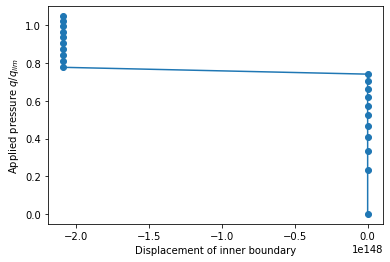

In [13]:
if len(points_on_proc) > 0:
    import matplotlib.pyplot as plt
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()